# Measuring BMI in OpenSAFELY-TPP
This short report describes how BMI can be identified in the OpenSAFELY-TPP database, and the strengths and weaknesses of the methods. This is a living document that will be updated to reflect changes to the OpenSAFELY-TPP database and the patient records within.

## OpenSAFELY
OpenSAFELY is an analytics platform for conducting analyses on Electronic Health Records inside the secure environment where the records are held. This has multiple benefits: 

* We don't transport large volumes of potentially disclosive pseudonymised patient data outside of the secure environments for analysis
* Analyses can run in near real-time as records are ready for analysis as soon as they appear in the secure environment
* All infrastructure and analysis code is stored in GitHub repositories, which are open for security review, scientific review, and re-use

A key feature of OpenSAFELY is the use of study definitions, which are formal specifications of the datasets to be generated from the OpenSAFELY database. This takes care of much of the complex EHR data wrangling required to create a dataset in an analysis-ready format. It also creates a library of standardised and validated variable definitions that can be deployed consistently across multiple projects. 

The purpose of this report is to describe all such variables that relate to BMI, their relative strengths and weaknesses, in what scenarios they are best deployed. It will also describe potential future definitions that have not yet been implemented.

## Available Records
OpenSAFELY-TPP runs inside TPP’s data centre which contains the primary care records for all patients registered at practices using TPP’s SystmOne Clinical Information System. This data centre also imports external datasets from other sources, including A&E attendances and hospital admissions from NHS Digital’s Secondary Use Service, and death registrations from the ONS. More information on available data sources can be found within the OpenSAFELY documentation. 

In [1]:
from IPython.display import display, Markdown
from lib import *

pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None 

In [2]:
### CONFIGURE OPTIONS HERE ###

# Import file
input_path = '../output/data/input_processed.feather'

# Definitions
definitions = ['derived_bmi', 'computed_bmi', 'recorded_bmi']

# Code dictionary
code_dict = ''

# Other variables to include
other_vars = ['height','weight']

# Dates
date_min = '2015-03-01'
date_max = '2022-03-01'
time_delta = 'M'

# Min/max range
min_range = 4
max_range = 200

# Null value – could be multiple values in a list [0,'0',NA]
null = [0]

# Covariates
demographic_covariates = ['age_band', 'sex', 'ethnicity', 'region', 'imd']
clinical_covariates = ['dementia', 'diabetes', 'hypertension', 'learning_disability']

In [3]:
df_clean = import_clean(input_path, definitions, other_vars, demographic_covariates, clinical_covariates, null, time_delta, code_dict, dates=True)

## Methods
 
We define three variable phenotypes: computed, recorded, and derived BMI. 
* Computed BMI refers to BMI calculated from height and weight measurements. 
* Recorded BMI refers to coded events of BMI. 
* Derived BMI refers to the canonical definition used in the OpenSAFELY backend using the `most_recent_bmi()` function, which returns patients' most recent BMI (in the defined period) either computed from weight and height measurements or, where they are not availble, from recorded BMI values.

To evaluate how well each of these phenotypes are populated, we count the number of patients with each phenotype, number of patients missing each phenotype, and number of patients with multiple phenotypes. We also examine the plausibility of each phenotype by looking at the distribution of measurements and counting values out of the expected range. To evaluate how frequently the BMI phenotypes are recorded, we track the number of new measurements recorded over time and compute the average time between updates.

For each of the checks above, we look at the whole population and across each of the following demographic and clinical subgroups to detect any inequalities.

Demographic covariates:
* Age band 
* Sex
* Ethnicity 
* Region
* IMD

Clinical covariates:
* Dementia
* Diabetes
* Hypertension
* Learning disability

## Results

### Count of Patients

In [4]:
patient_counts(df_clean, definitions, demographic_covariates, clinical_covariates)

derived_bmi    computed_bmi  \
group               subgroup                                                   
population          N                                   1000            1000   
                    with records              1000.0 (100.0)  1000.0 (100.0)   
age_band            0-19                        125.0 (12.5)    125.0 (12.5)   
                    20-29                       120.0 (12.0)    120.0 (12.0)   
                    30-39                       145.0 (14.5)    145.0 (14.5)   
                    40-49                       135.0 (13.5)    135.0 (13.5)   
                    50-59                       115.0 (11.5)    115.0 (11.5)   
                    60-69                       130.0 (13.0)    130.0 (13.0)   
                    70-79                       105.0 (10.5)    105.0 (10.5)   
                    80+                         130.0 (13.0)    130.0 (13.0)   
sex                 F                           495.0 (49.5)    490.0 (49.0)   
                    M                           505.0 (50.5)    505.0 (50.5)   
ethnicity           1                           505.0 (50.5)    505.0 (50.5)   
                    2                           245.0 (24.5)    245.0 (24.5)   
                    3                           140.0 (14.0)    140.0 (14.0)   
                    4                             65.0 (6.5)      60.0 (6.0)   
                    5                             40.0 (4.0)      40.0 (4.0)   
region              East Midlands                 55.0 (5.5)      55.0 (5.5)   
                    East of England               65.0 (6.5)      65.0 (6.5)   
                    London                      130.0 (13.0)    130.0 (13.0)   
                    North East                    70.0 (7.0)      70.0 (7.0)   
                    North West                    75.0 (7.5)      75.0 (7.5)   
                    South East                  135.0 (13.5)    135.0 (13.5)   
                    West Midlands                 60.0 (6.0)      60.0 (6.0)   
                    Yorkshire and the Humber      60.0 (6.0)      60.0 (6.0)   
imd                 0                             10.0 (1.0)      10.0 (1.0)   
                    1                           205.0 (20.5)    205.0 (20.5)   
                    2                           185.0 (18.5)    185.0 (18.5)   
                    3                           205.0 (20.5)    205.0 (20.5)   
                    4                           185.0 (18.5)    185.0 (18.5)   
                    5                           200.0 (20.0)    200.0 (20.0)   
dementia            False                       990.0 (99.0)    990.0 (99.0)   
                    True                          10.0 (1.0)      10.0 (1.0)   
diabetes            False                       990.0 (99.0)    990.0 (99.0)   
                    True                          10.0 (1.0)      10.0 (1.0)   
hypertension        False                       990.0 (99.0)    990.0 (99.0)   
                    True                          10.0 (1.0)      10.0 (1.0)   
learning_disability False                       990.0 (99.0)    990.0 (99.0)   
                    True                          10.0 (1.0)      10.0 (1.0)   

                                                recorded_bmi      all_filled  
group               subgroup                                                  
population          N                                   1000            1000  
                    with records              1000.0 (100.0)  1000.0 (100.0)  
age_band            0-19                        125.0 (12.5)    125.0 (12.5)  
                    20-29                       120.0 (12.0)    120.0 (12.0)  
                    30-39                       145.0 (14.5)    145.0 (14.5)  
                    40-49                       135.0 (13.5)    135.0 (13.5)  
                    50-59                       115.0 (11.5)    115.0 (11.5)  
                    60-69                       130.0 (13

### Count of Missings

In [5]:
patient_counts(df_clean, definitions, demographic_covariates, clinical_covariates, missing=True)

derived_bmi computed_bmi  \
group               subgroup                                            
population          N                               1000         1000   
                    missing records                - (-)        - (-)   
age_band            0-19                           - (-)        - (-)   
                    20-29                          - (-)        - (-)   
                    30-39                          - (-)        - (-)   
                    40-49                          - (-)        - (-)   
                    50-59                          - (-)        - (-)   
                    60-69                          - (-)        - (-)   
                    70-79                          - (-)        - (-)   
                    80+                            - (-)        - (-)   
sex                 F                              - (-)        - (-)   
                    M                              - (-)        - (-)   
ethnicity           1                              - (-)        - (-)   
                    2                              - (-)        - (-)   
                    3                              - (-)        - (-)   
                    4                              - (-)        - (-)   
                    5                              - (-)        - (-)   
region              East Midlands                  - (-)        - (-)   
                    East of England                - (-)        - (-)   
                    London                         - (-)        - (-)   
                    North East                     - (-)        - (-)   
                    North West                     - (-)        - (-)   
                    South East                     - (-)        - (-)   
                    West Midlands                  - (-)        - (-)   
                    Yorkshire and the Humber       - (-)        - (-)   
imd                 0                              - (-)        - (-)   
                    1                              - (-)        - (-)   
                    2                              - (-)        - (-)   
                    3                              - (-)        - (-)   
                    4                              - (-)        - (-)   
                    5                              - (-)        - (-)   
dementia            False                          - (-)        - (-)   
                    True                           - (-)        - (-)   
diabetes            False                          - (-)        - (-)   
                    True                           - (-)        - (-)   
hypertension        False                          - (-)        - (-)   
                    True                           - (-)        - (-)   
learning_disability False                          - (-)        - (-)   
                    True                           - (-)        - (-)   

                                             recorded_bmi all_missing  
group               subgroup                                           
population          N                                1000        1000  
                    missing records                 - (-)       - (-)  
age_band            0-19                            - (-)       - (-)  
                    20-29                           - (-)       - (-)  
                    30-39                           - (-)       - (-)  
                    40-49                           - (-)       - (-)  
                    50-59                           - (-)       - (-)  
                    60-69                           - (-)       - (-)  
                    70-79                           - (-)       - (-)  
                    80+                             - (-)       - (-)  
sex                 F                               - (-)       - (-)  
                    M                               - (-)       - (-)  
ethnicity           1                      

### Overlapping Definitions

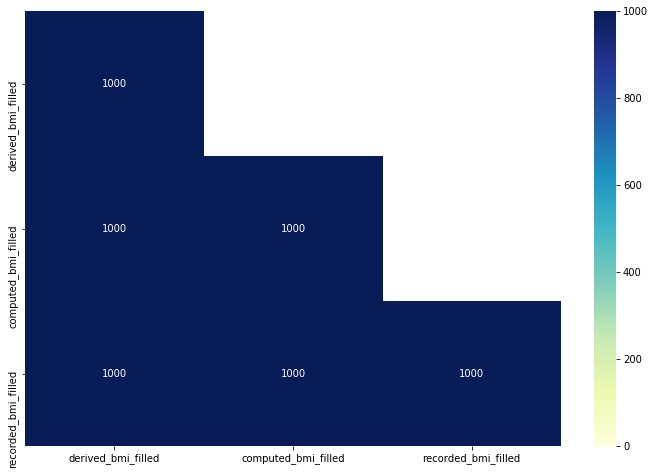

In [6]:
display_heatmap(df_clean, definitions)

### Distribution of Values

#### Height and Weight – Inputs for Computed BMI

/opt/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


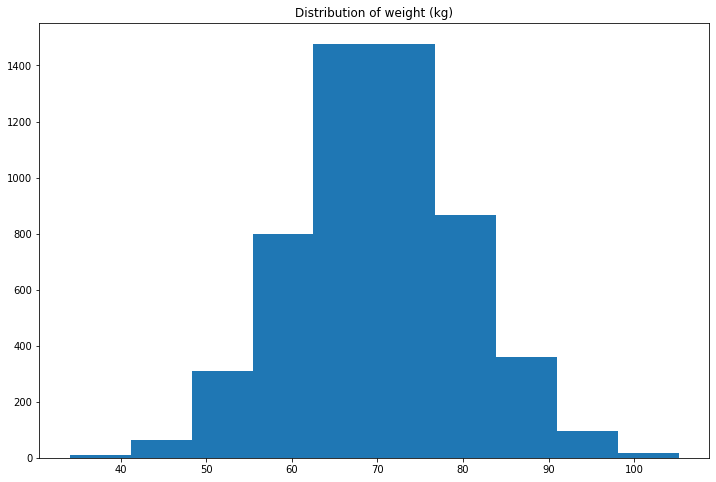

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist(df_clean['weight'])
plt.title('Distribution of weight (kg)')
plt.show()

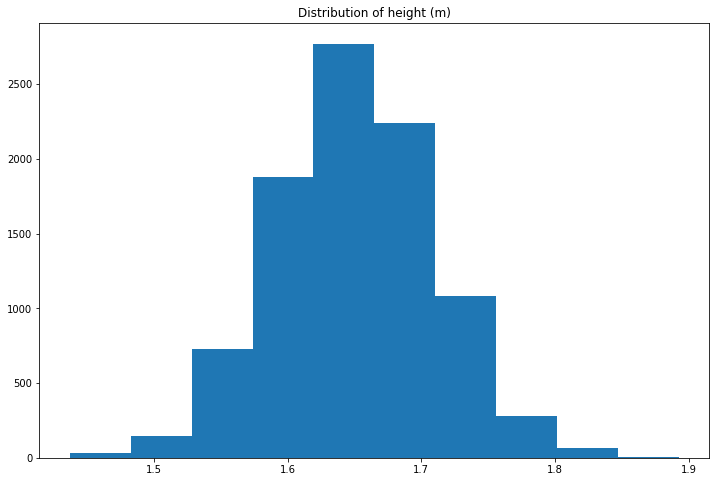

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist(df_clean['height'])
plt.title('Distribution of height (m)')
plt.show()

#### Comparison of Distributions

Averages:



,mean,count
derived_bmi,27.961124,8010
computed_bmi,25.846552,5040
recorded_bmi,21.944629,7000


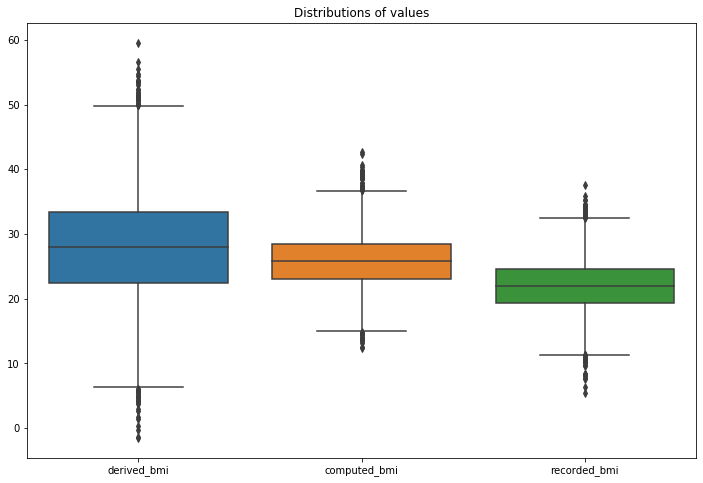

Averages by age_band:



,avg_derived_bmi,avg_computed_bmi,avg_recorded_bmi,ct_derived_bmi,ct_computed_bmi,ct_recorded_bmi
age_band,,,,,,
0-19,27.7384,25.6201,21.8955,995,650,895
20-29,27.7532,26.0954,21.7731,965,580,835
30-39,27.767,25.8525,22.128,1155,735,1020
40-49,28.2345,25.9937,22.0498,1070,690,930
50-59,28.3111,25.7798,21.7407,930,585,805
60-69,28.0937,25.7501,22.0621,1025,650,885
70-79,27.5825,26.1885,22.0422,820,490,715
80+,28.1512,25.5932,21.8283,1055,665,920


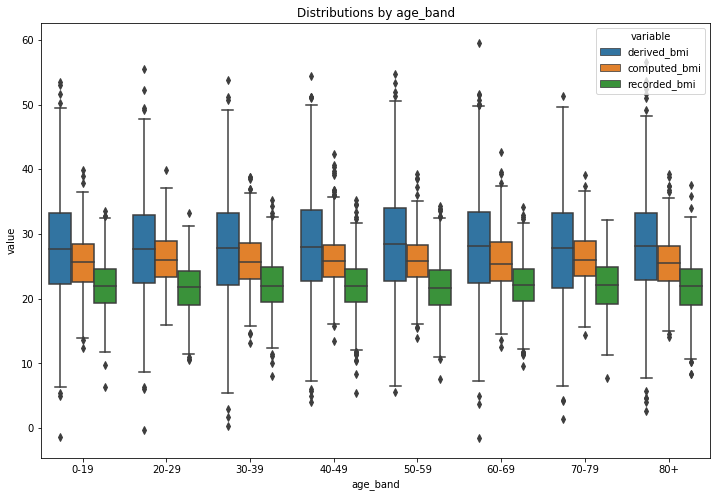

Averages by sex:



,avg_derived_bmi,avg_computed_bmi,avg_recorded_bmi,ct_derived_bmi,ct_computed_bmi,ct_recorded_bmi
sex,,,,,,
F,27.9395,25.8402,21.9762,3955,2460,3450
M,27.9822,25.8526,21.9139,4055,2580,3550


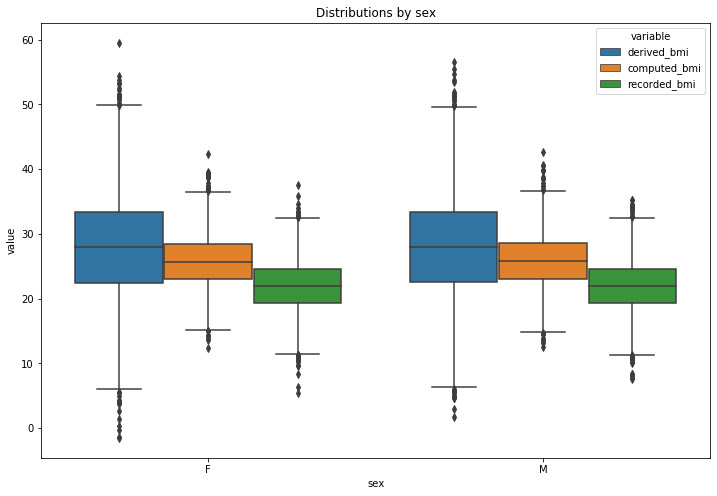

Averages by ethnicity:



,avg_derived_bmi,avg_computed_bmi,avg_recorded_bmi,ct_derived_bmi,ct_computed_bmi,ct_recorded_bmi
ethnicity,,,,,,
1,27.7435,25.8459,21.9595,4065,2510,3560
2,28.0795,25.6727,21.9088,1970,1260,1745
3,28.3313,26.0243,21.9705,1125,715,970
4,28.0466,25.9308,21.9849,495,320,430
5,28.5038,26.1328,21.8322,355,235,290


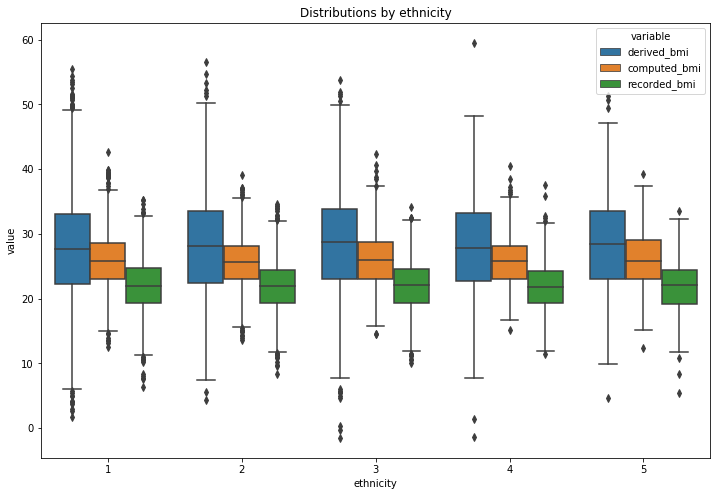

Averages by region:



,avg_derived_bmi,avg_computed_bmi,avg_recorded_bmi,ct_derived_bmi,ct_computed_bmi,ct_recorded_bmi
region,,,,,,
East Midlands,27.8028,25.9425,21.6376,430,280,395
East of England,27.9667,25.7511,22.0438,540,355,460
London,28.3584,25.7154,22.026,1015,650,895
North East,28.2319,25.9992,21.7222,560,350,490
North West,27.7438,25.9274,21.9588,620,390,525
South East,27.9621,25.7072,21.7883,1055,710,955
West Midlands,28.3719,25.8237,22.1414,480,285,415
Yorkshire and the Humber,28.1615,25.9157,21.8947,485,295,430


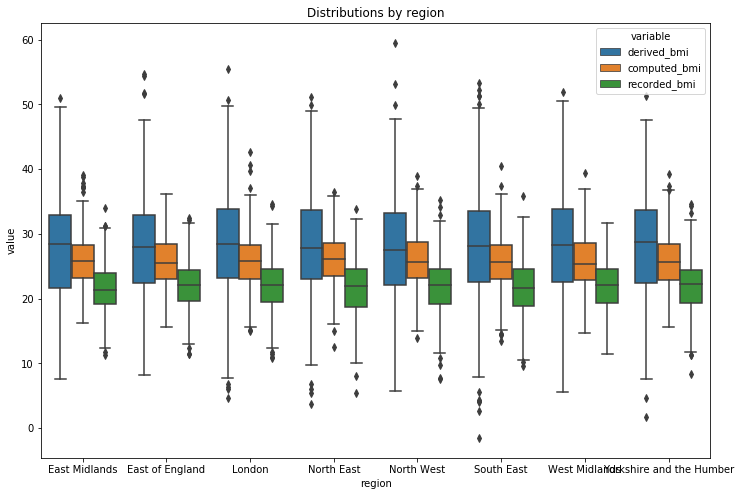

Averages by imd:



,avg_derived_bmi,avg_computed_bmi,avg_recorded_bmi,ct_derived_bmi,ct_computed_bmi,ct_recorded_bmi
imd,,,,,,
0,28.0275,25.5046,21.7317,95,60,90
1,27.7563,25.9348,22.0384,1650,1045,1450
2,27.6429,25.761,21.8344,1505,935,1335
3,27.8746,25.9207,22.094,1670,1030,1445
4,28.5558,25.8637,21.8445,1490,950,1285
5,28.0047,25.7645,21.9045,1600,1020,1400


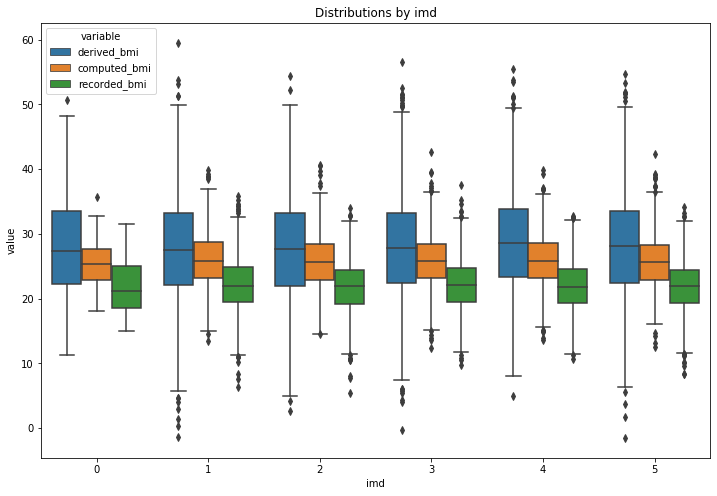

Averages by dementia:



,avg_derived_bmi,avg_computed_bmi,avg_recorded_bmi,ct_derived_bmi,ct_computed_bmi,ct_recorded_bmi
dementia,,,,,,
False,27.9761,25.8542,21.9423,7930,4990,6935
True,26.5148,25.0817,22.1889,80,50,65


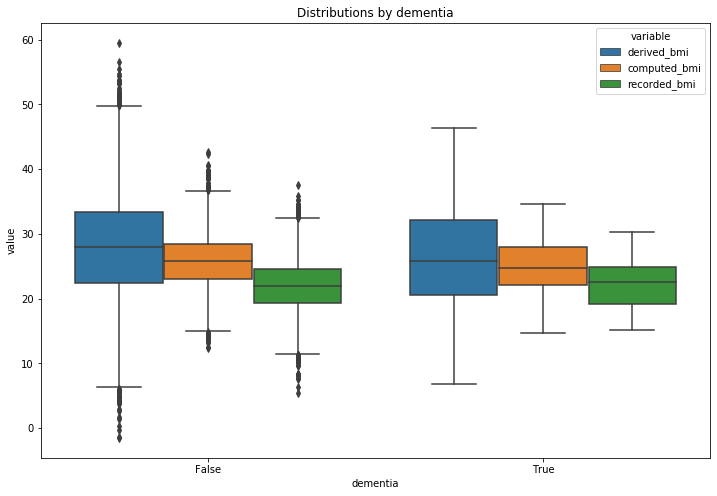

Averages by diabetes:



,avg_derived_bmi,avg_computed_bmi,avg_recorded_bmi,ct_derived_bmi,ct_computed_bmi,ct_recorded_bmi
diabetes,,,,,,
False,27.9527,25.8546,21.947,7935,4985,6930
True,28.8537,25.1211,21.7089,75,55,70


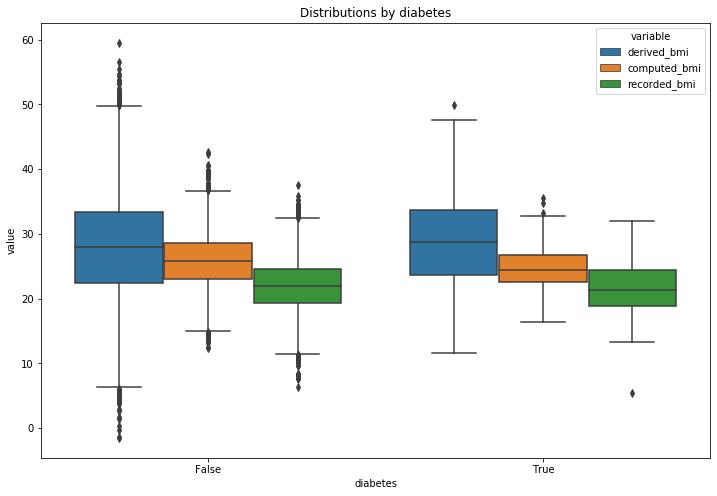

Averages by hypertension:



,avg_derived_bmi,avg_computed_bmi,avg_recorded_bmi,ct_derived_bmi,ct_computed_bmi,ct_recorded_bmi
hypertension,,,,,,
False,27.9525,25.8416,21.9482,7930,4990,6930
True,28.8381,26.3105,21.5996,80,55,70


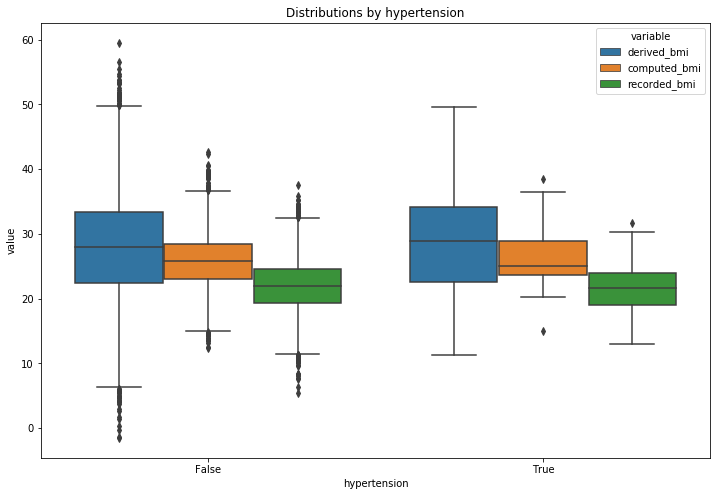

Averages by learning_disability:



,avg_derived_bmi,avg_computed_bmi,avg_recorded_bmi,ct_derived_bmi,ct_computed_bmi,ct_recorded_bmi
learning_disability,,,,,,
False,27.9613,25.8463,21.9435,7930,4990,6930
True,27.9385,25.871,22.0582,80,55,70


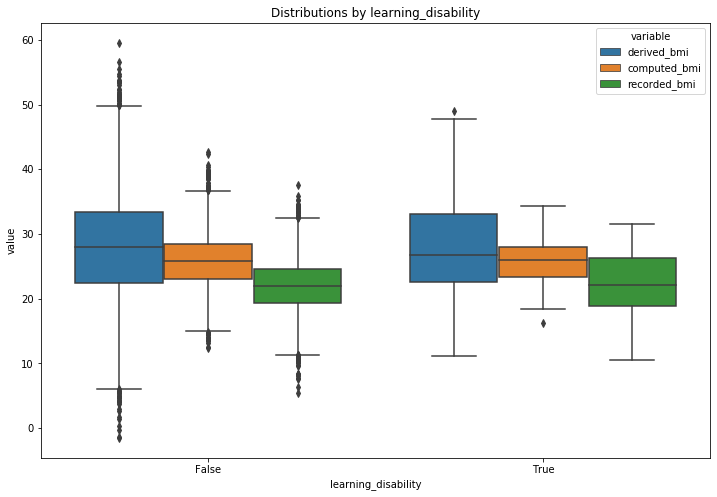

In [9]:
report_distribution(df_clean, definitions, len(definitions), group='')
for group in demographic_covariates + clinical_covariates:
    report_distribution(df_clean, definitions, len(definitions), group)

#### Out-of-Range Values

,oor_derived_bmi,oor_computed_bmi,oor_recorded_bmi
index,,,
count,-,-,-
mean,-,-,-
pct25,-,-,-
pct75,-,-,-


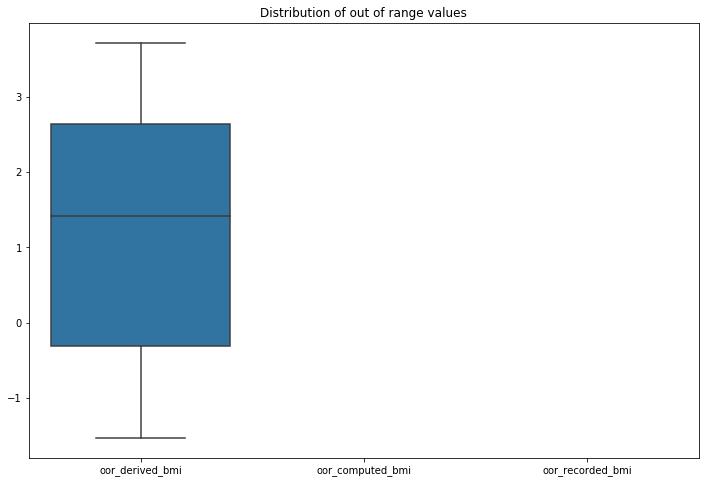

In [10]:
report_out_of_range(df_clean, definitions, min_range, max_range, len(definitions), null, group='')

,count_derived_bmi,mean_derived_bmi,pct25_derived_bmi,pct75_derived_bmi,count_computed_bmi,mean_computed_bmi,pct25_computed_bmi,pct75_computed_bmi,count_recorded_bmi,mean_recorded_bmi,pct25_recorded_bmi,pct75_recorded_bmi
age_band,,,,,,,,,,,,
0-19,-,-,-,-,-,-,-,-,-,-,-,-
20-29,-,-,-,-,-,-,-,-,-,-,-,-
30-39,-,-,-,-,-,-,-,-,-,-,-,-
40-49,-,-,-,-,-,-,-,-,-,-,-,-
50-59,-,-,-,-,-,-,-,-,-,-,-,-
60-69,-,-,-,-,-,-,-,-,-,-,-,-
70-79,-,-,-,-,-,-,-,-,-,-,-,-
80+,-,-,-,-,-,-,-,-,-,-,-,-


Plot redacted due to low counts.


,count_derived_bmi,mean_derived_bmi,pct25_derived_bmi,pct75_derived_bmi,count_computed_bmi,mean_computed_bmi,pct25_computed_bmi,pct75_computed_bmi,count_recorded_bmi,mean_recorded_bmi,pct25_recorded_bmi,pct75_recorded_bmi
sex,,,,,,,,,,,,
F,-,-,-,-,-,-,-,-,-,-,-,-
M,-,-,-,-,-,-,-,-,-,-,-,-


Plot redacted due to low counts.


,count_derived_bmi,mean_derived_bmi,pct25_derived_bmi,pct75_derived_bmi,count_computed_bmi,mean_computed_bmi,pct25_computed_bmi,pct75_computed_bmi,count_recorded_bmi,mean_recorded_bmi,pct25_recorded_bmi,pct75_recorded_bmi
ethnicity,,,,,,,,,,,,
1,-,-,-,-,-,-,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-,-,-,-,-
3,-,-,-,-,-,-,-,-,-,-,-,-
4,-,-,-,-,-,-,-,-,-,-,-,-
5,-,-,-,-,-,-,-,-,-,-,-,-


Plot redacted due to low counts.


,count_derived_bmi,mean_derived_bmi,pct25_derived_bmi,pct75_derived_bmi,count_computed_bmi,mean_computed_bmi,pct25_computed_bmi,pct75_computed_bmi,count_recorded_bmi,mean_recorded_bmi,pct25_recorded_bmi,pct75_recorded_bmi
region,,,,,,,,,,,,
East Midlands,-,-,-,-,-,-,-,-,-,-,-,-
East of England,-,-,-,-,-,-,-,-,-,-,-,-
London,-,-,-,-,-,-,-,-,-,-,-,-
North East,-,-,-,-,-,-,-,-,-,-,-,-
North West,-,-,-,-,-,-,-,-,-,-,-,-
South East,-,-,-,-,-,-,-,-,-,-,-,-
West Midlands,-,-,-,-,-,-,-,-,-,-,-,-
Yorkshire and the Humber,-,-,-,-,-,-,-,-,-,-,-,-


Plot redacted due to low counts.


,count_derived_bmi,mean_derived_bmi,pct25_derived_bmi,pct75_derived_bmi,count_computed_bmi,mean_computed_bmi,pct25_computed_bmi,pct75_computed_bmi,count_recorded_bmi,mean_recorded_bmi,pct25_recorded_bmi,pct75_recorded_bmi
imd,,,,,,,,,,,,
0,-,-,-,-,-,-,-,-,-,-,-,-
1,-,-,-,-,-,-,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-,-,-,-,-
3,-,-,-,-,-,-,-,-,-,-,-,-
4,-,-,-,-,-,-,-,-,-,-,-,-
5,-,-,-,-,-,-,-,-,-,-,-,-


Plot redacted due to low counts.


,count_derived_bmi,mean_derived_bmi,pct25_derived_bmi,pct75_derived_bmi,count_computed_bmi,mean_computed_bmi,pct25_computed_bmi,pct75_computed_bmi,count_recorded_bmi,mean_recorded_bmi,pct25_recorded_bmi,pct75_recorded_bmi
dementia,,,,,,,,,,,,
False,10,1.06866,-0.311117,2.64225,-,-,-,-,-,-,-,-
True,-,-,-,-,-,-,-,-,-,-,-,-


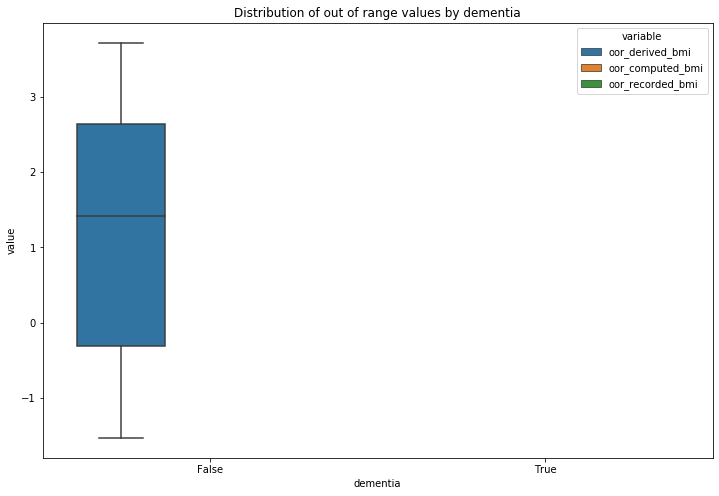

,count_derived_bmi,mean_derived_bmi,pct25_derived_bmi,pct75_derived_bmi,count_computed_bmi,mean_computed_bmi,pct25_computed_bmi,pct75_computed_bmi,count_recorded_bmi,mean_recorded_bmi,pct25_recorded_bmi,pct75_recorded_bmi
diabetes,,,,,,,,,,,,
False,10,1.06866,-0.311117,2.64225,-,-,-,-,-,-,-,-
True,-,-,-,-,-,-,-,-,-,-,-,-


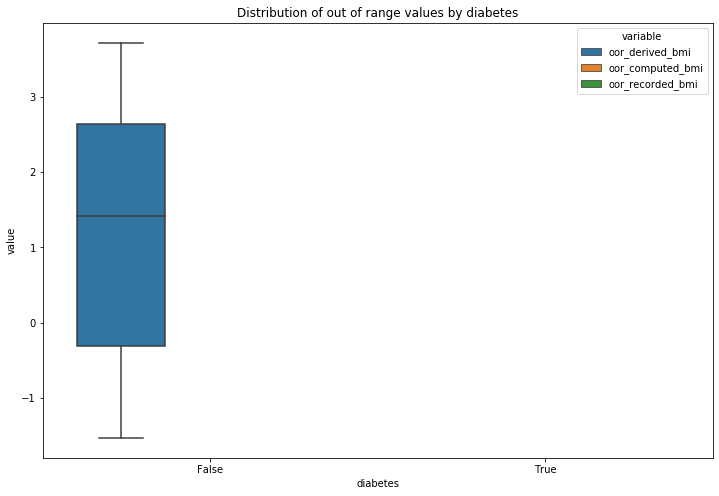

,count_derived_bmi,mean_derived_bmi,pct25_derived_bmi,pct75_derived_bmi,count_computed_bmi,mean_computed_bmi,pct25_computed_bmi,pct75_computed_bmi,count_recorded_bmi,mean_recorded_bmi,pct25_recorded_bmi,pct75_recorded_bmi
hypertension,,,,,,,,,,,,
False,10,1.06866,-0.311117,2.64225,-,-,-,-,-,-,-,-
True,-,-,-,-,-,-,-,-,-,-,-,-


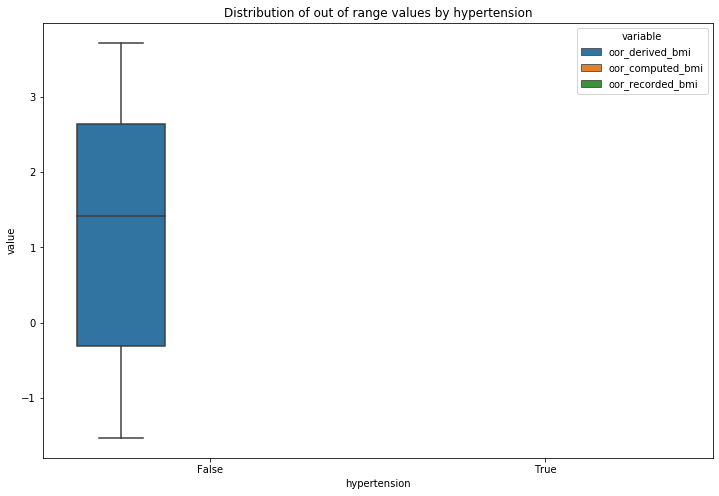

,count_derived_bmi,mean_derived_bmi,pct25_derived_bmi,pct75_derived_bmi,count_computed_bmi,mean_computed_bmi,pct25_computed_bmi,pct75_computed_bmi,count_recorded_bmi,mean_recorded_bmi,pct25_recorded_bmi,pct75_recorded_bmi
learning_disability,,,,,,,,,,,,
False,10,1.06866,-0.311117,2.64225,-,-,-,-,-,-,-,-
True,-,-,-,-,-,-,-,-,-,-,-,-


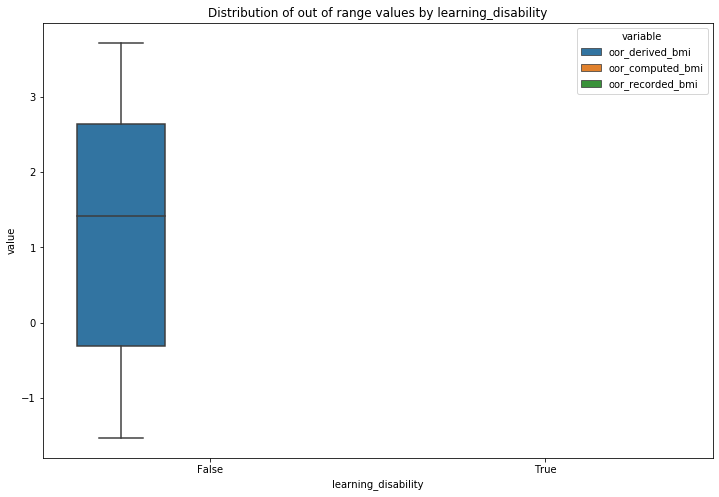

In [11]:
for group in demographic_covariates + clinical_covariates:
    report_out_of_range(df_clean, definitions, min_range, max_range, len(definitions), null, group)

### Number of Patients Over Time

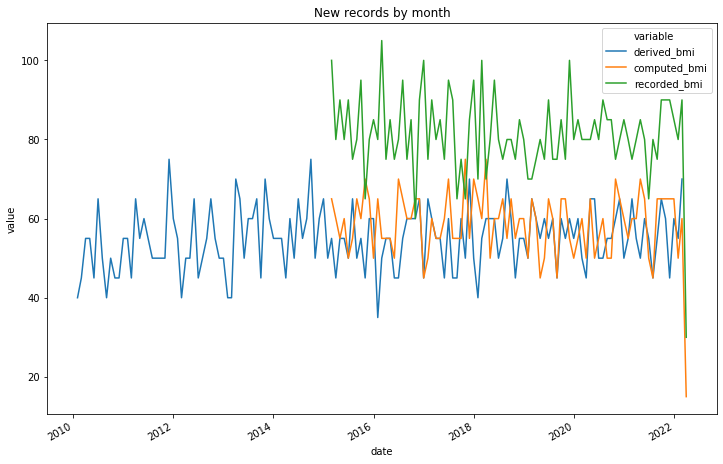

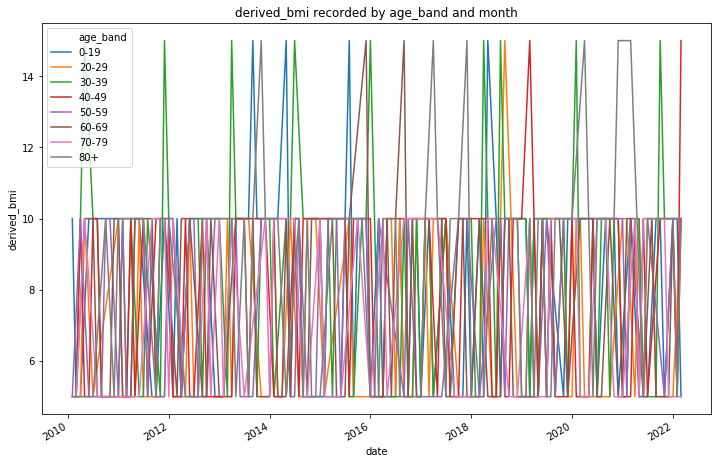

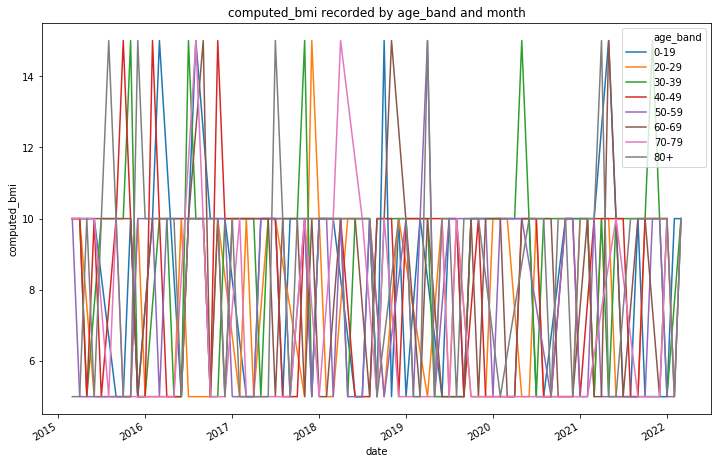

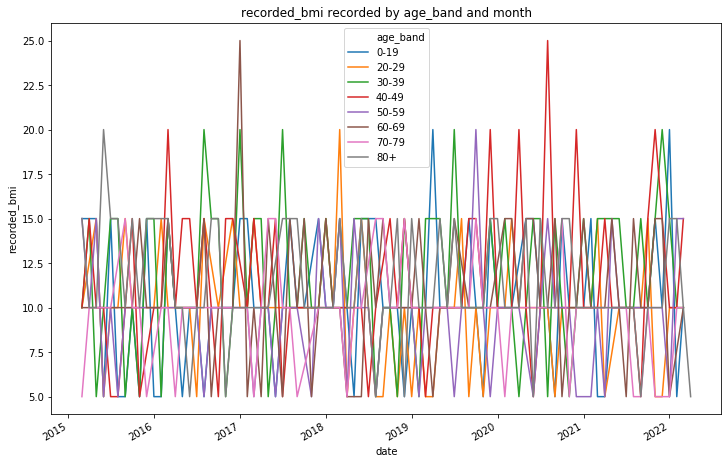

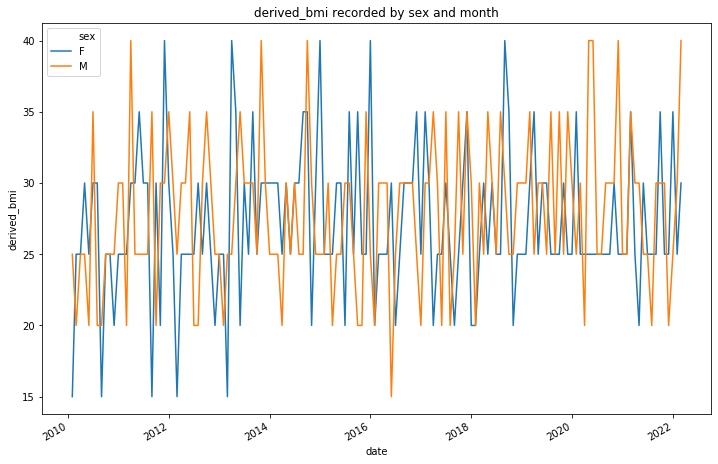

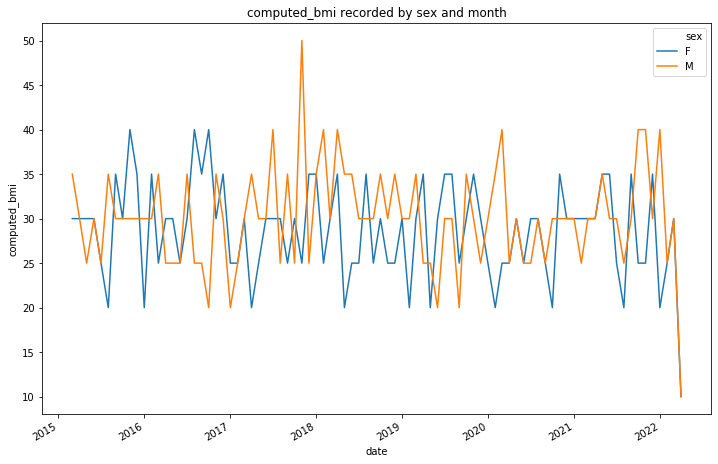

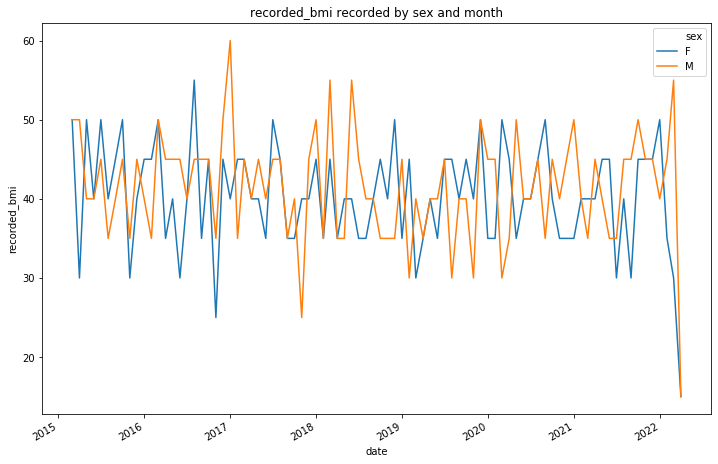

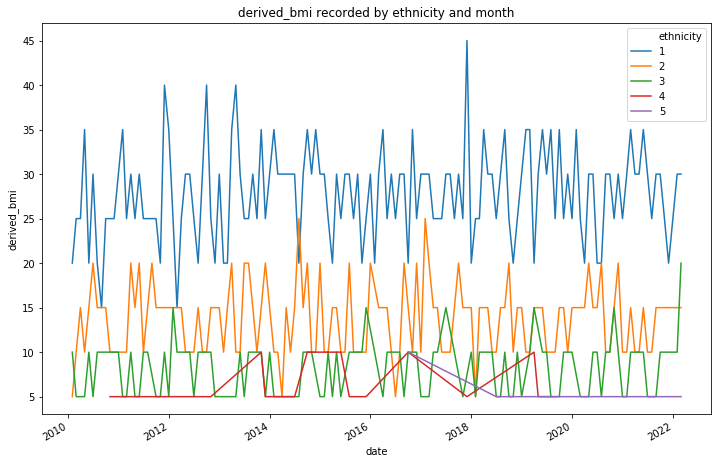

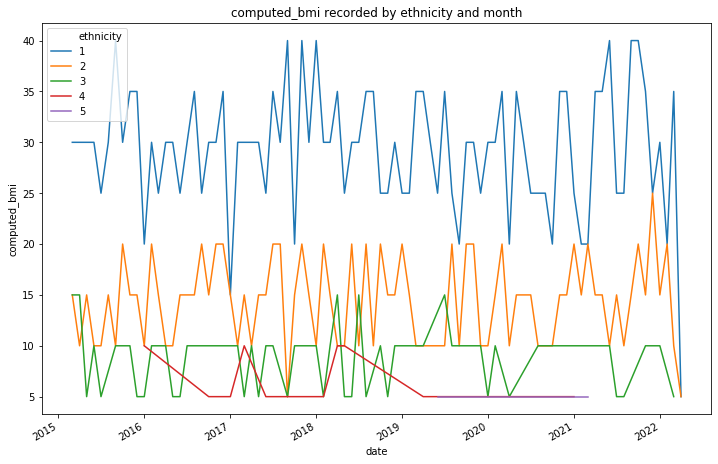

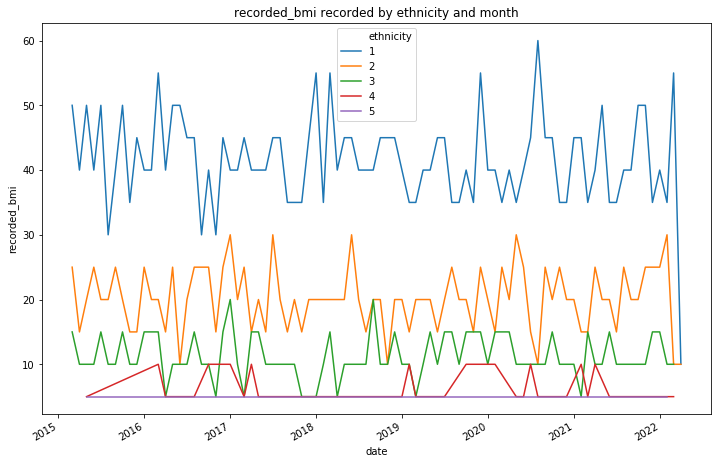

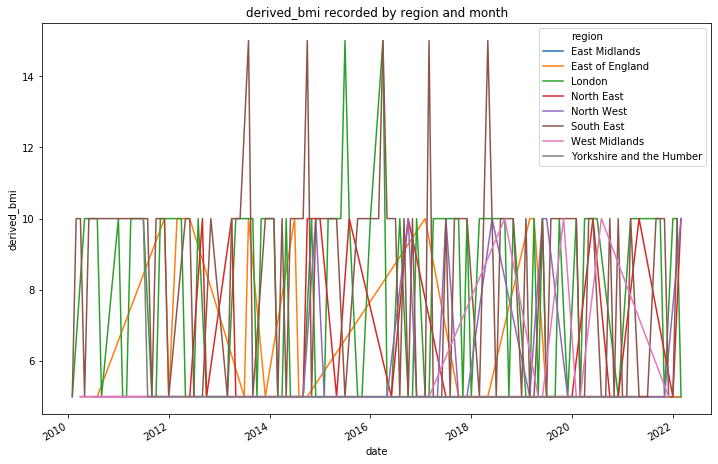

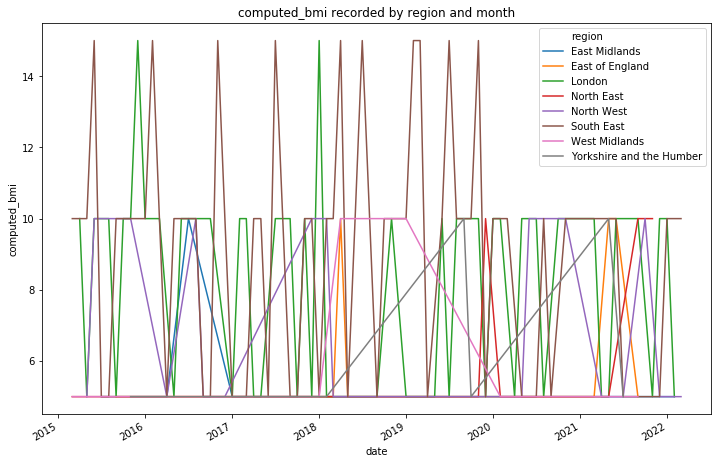

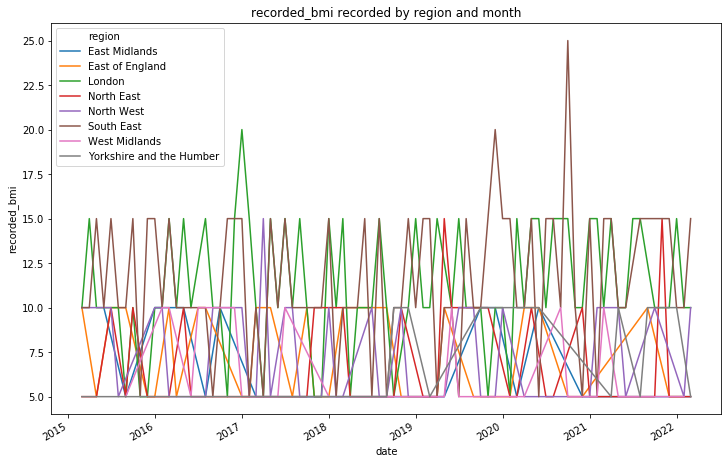

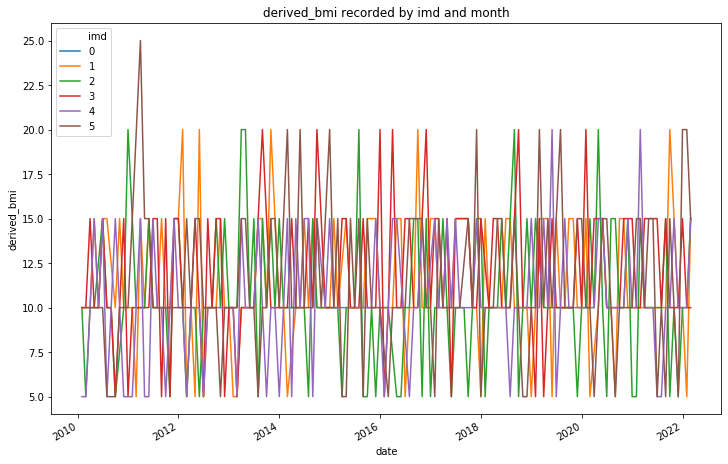

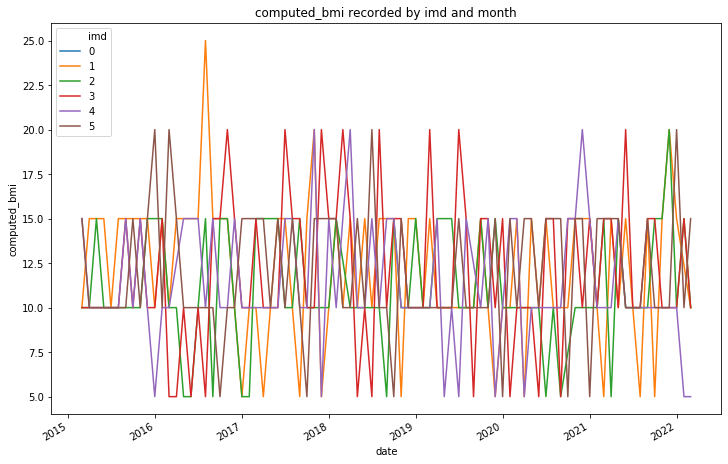

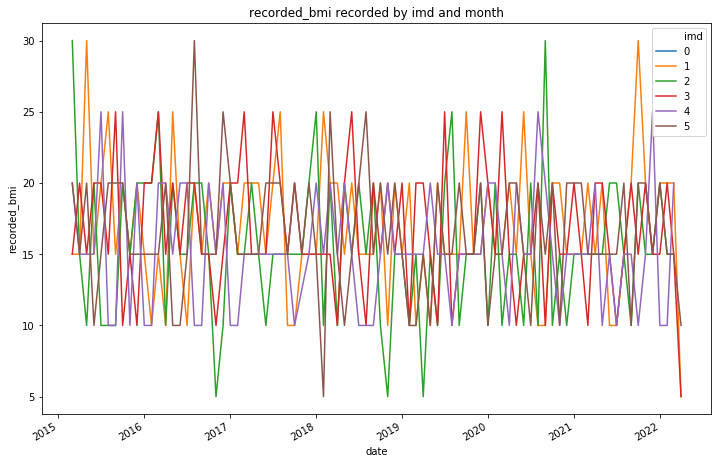

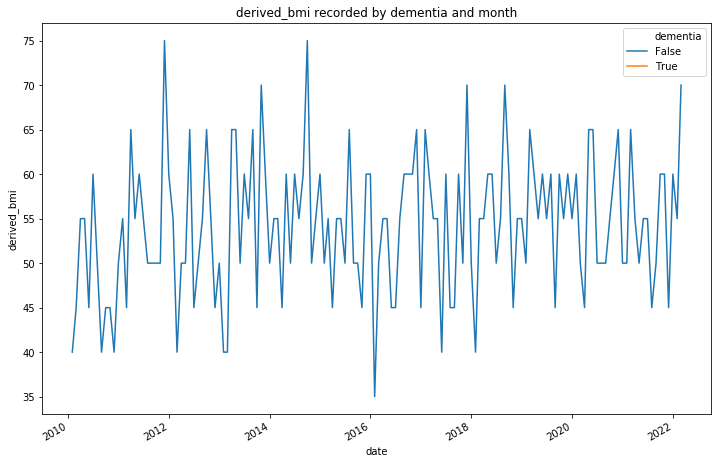

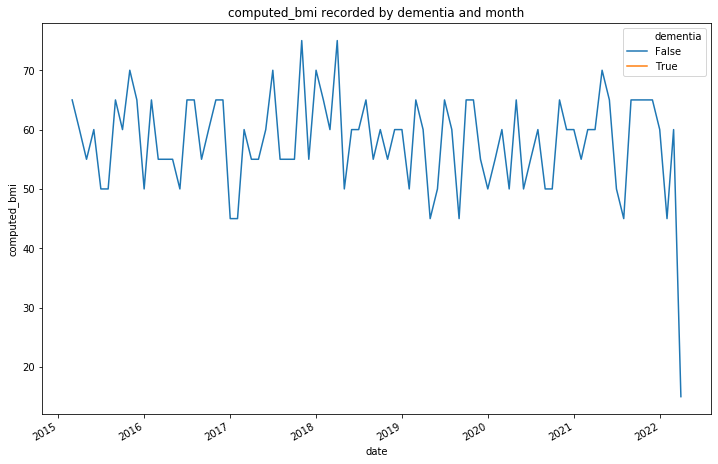

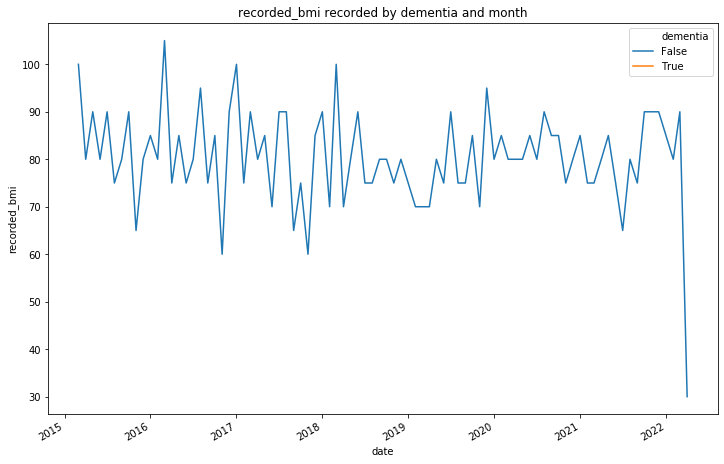

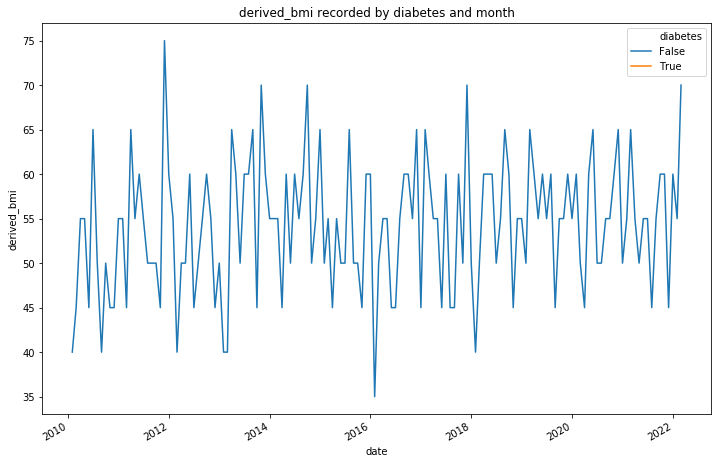

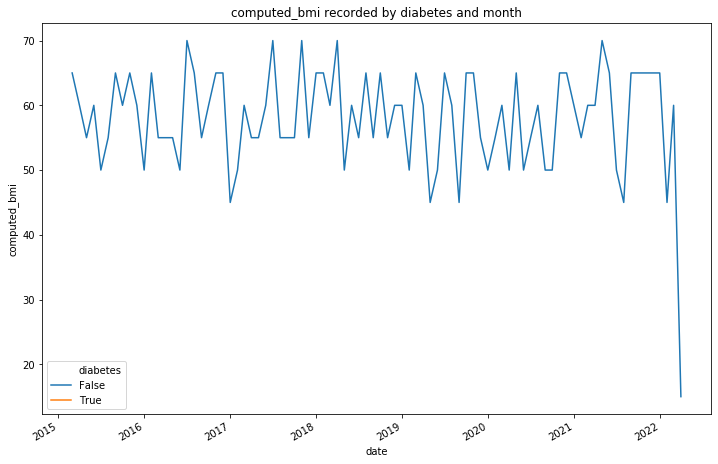

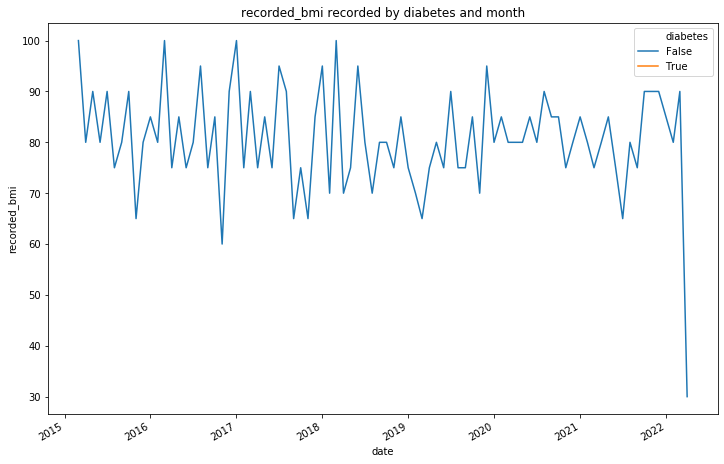

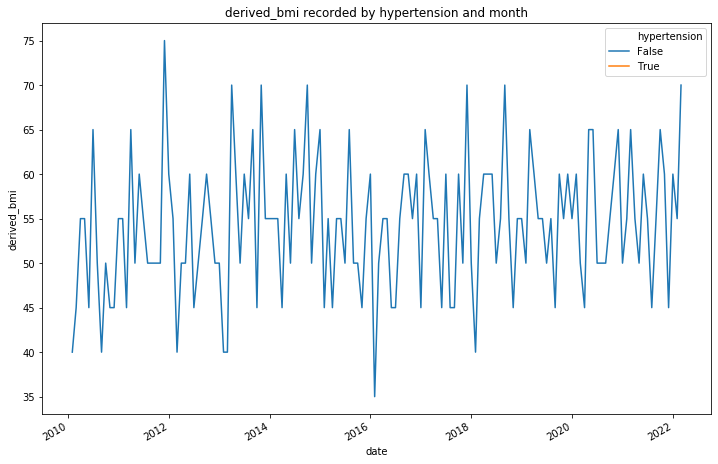

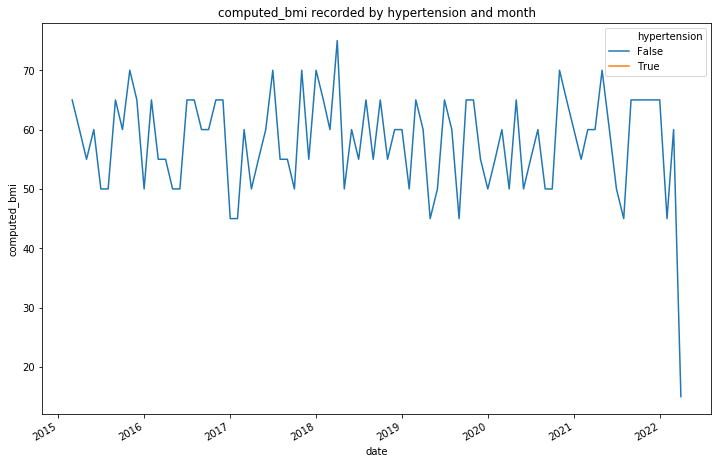

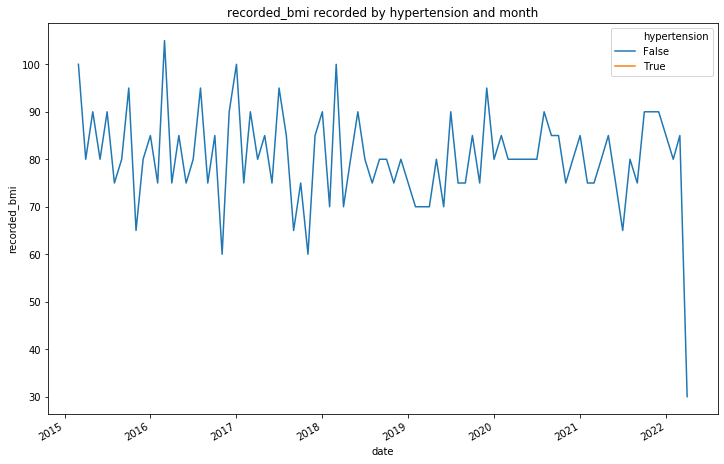

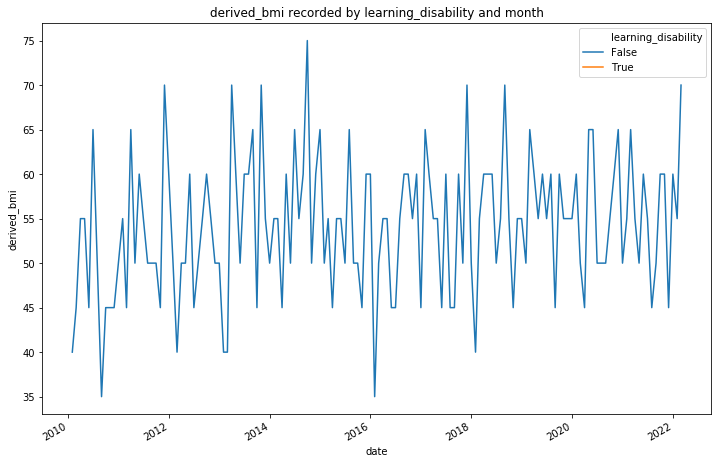

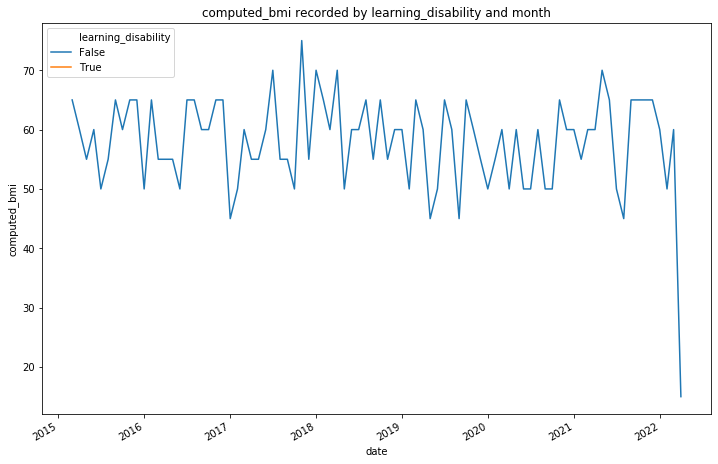

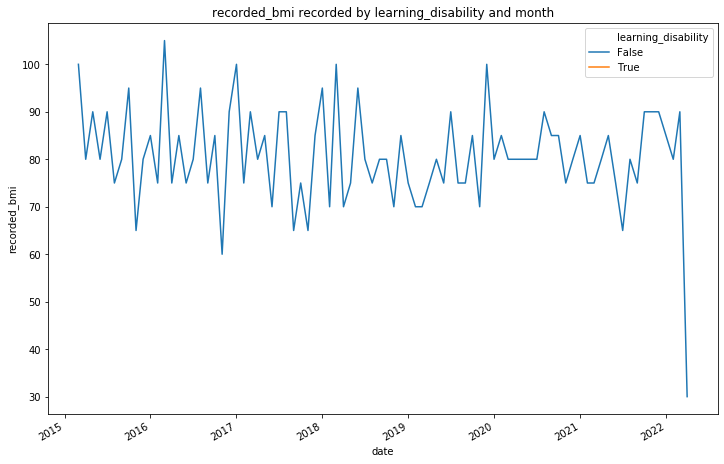

In [12]:
records_over_time(df_clean, definitions, demographic_covariates, clinical_covariates)

### Average Time Between Updates

Average update frequency by M:



,avg_diff,count
date_diff_derived_bmi,16.062625,7010
date_diff_computed_bmi,12.755084,4475
date_diff_recorded_bmi,10.644333,6000


/opt/venv/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


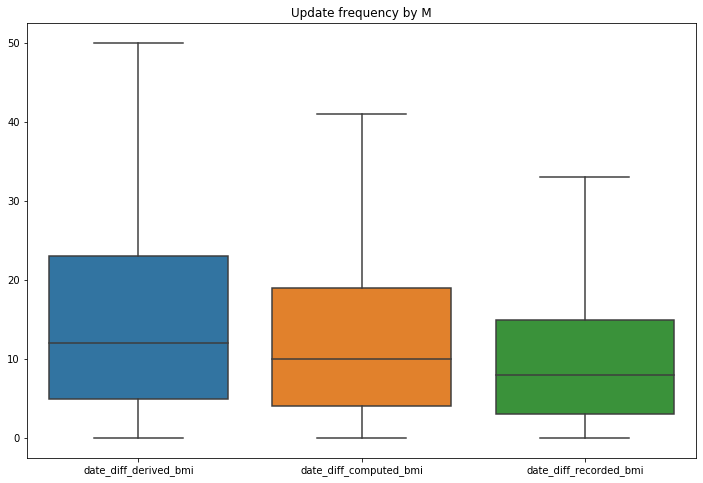

In [13]:
report_update_frequency(df_clean, definitions, time_delta, len(definitions), group='')

Average update frequencies by M:



,avg_date_diff_derived_bmi,avg_date_diff_computed_bmi,avg_date_diff_recorded_bmi,ct_date_diff_derived_bmi,ct_date_diff_computed_bmi,ct_date_diff_recorded_bmi
age_band,,,,,,
0-19,16.2491,12.4679,10.4512,865,575,770
20-29,16.0178,12.7069,10.5056,845,520,715
30-39,16.1594,12.1674,10.3596,1010,675,875
40-49,16.1429,13.0353,10.9081,940,595,795
50-59,16.0209,13.2481,10.9302,815,520,690
60-69,16.0435,12.6335,10.8674,895,575,755
70-79,16.3497,12.9862,10.5768,715,435,610
80+,15.5747,12.9862,10.599,925,580,795


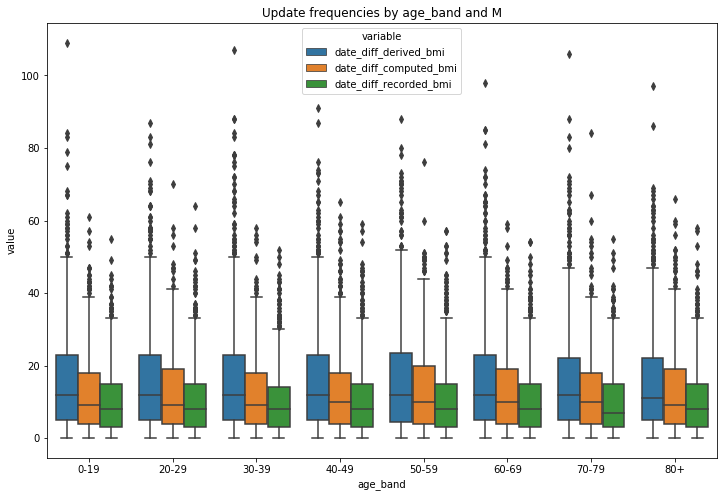

Average update frequencies by M:



,avg_date_diff_derived_bmi,avg_date_diff_computed_bmi,avg_date_diff_recorded_bmi,ct_date_diff_derived_bmi,ct_date_diff_computed_bmi,ct_date_diff_recorded_bmi
sex,,,,,,
F,16.0173,12.7874,10.5015,3460,2185,2955
M,16.1068,12.7243,10.7831,3550,2290,3045


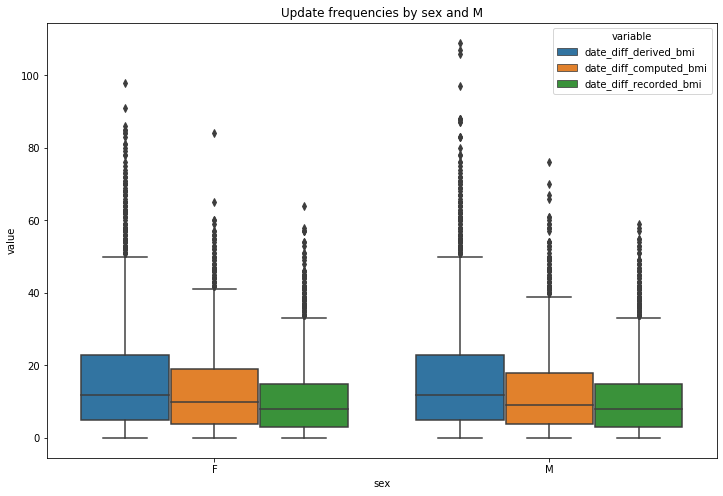

Average update frequencies by M:



,avg_date_diff_derived_bmi,avg_date_diff_computed_bmi,avg_date_diff_recorded_bmi,ct_date_diff_derived_bmi,ct_date_diff_computed_bmi,ct_date_diff_recorded_bmi
ethnicity,,,,,,
1,15.9374,12.9044,10.5969,3560,2240,3055
2,16.2281,12.7195,10.4492,1725,1125,1495
3,16.5756,13.0273,10.7817,985,625,830
4,15.8442,11.263,11.1274,430,290,370
5,15.2596,12.5941,11.224,310,200,250


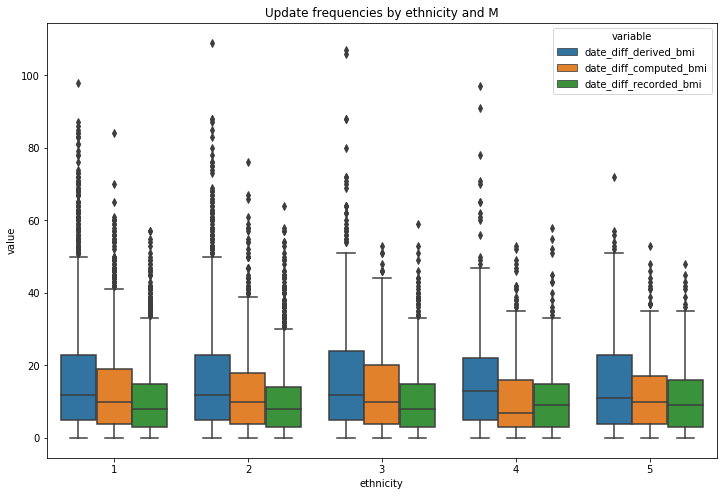

Average update frequencies by M:



,avg_date_diff_derived_bmi,avg_date_diff_computed_bmi,avg_date_diff_recorded_bmi,ct_date_diff_derived_bmi,ct_date_diff_computed_bmi,ct_date_diff_recorded_bmi
region,,,,,,
East Midlands,17.1277,12.845,10.5621,375,260,340
East of England,15.673,12.202,10.7544,475,305,395
London,16.5851,12.8052,10.7109,885,580,770
North East,16.8065,12.6097,10.4252,490,310,420
North West,15.7934,12.7625,10.8412,540,340,445
South East,16.1452,12.5097,10.6117,925,620,820
West Midlands,15.9045,12.7588,10.2051,420,255,355
Yorkshire and the Humber,15.8514,12.883,10.374,425,265,370


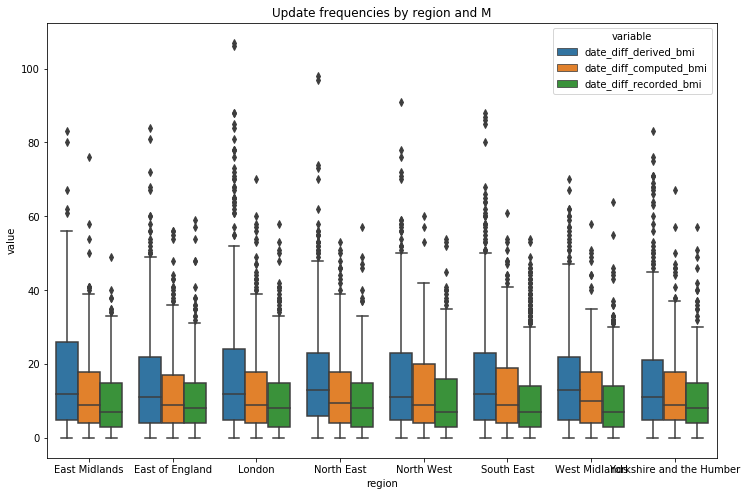

Average update frequencies by M:



,avg_date_diff_derived_bmi,avg_date_diff_computed_bmi,avg_date_diff_recorded_bmi,ct_date_diff_derived_bmi,ct_date_diff_computed_bmi,ct_date_diff_recorded_bmi
imd,,,,,,
0,16.1358,13.3214,9.2625,80,55,80
1,16.108,12.8024,10.6428,1445,910,1245
2,16.3136,12.9469,10.5575,1315,845,1150
3,15.6473,12.4775,10.6694,1465,915,1235
4,16.1382,12.436,10.7956,1300,845,1095
5,16.1401,13.0708,10.6572,1400,905,1195


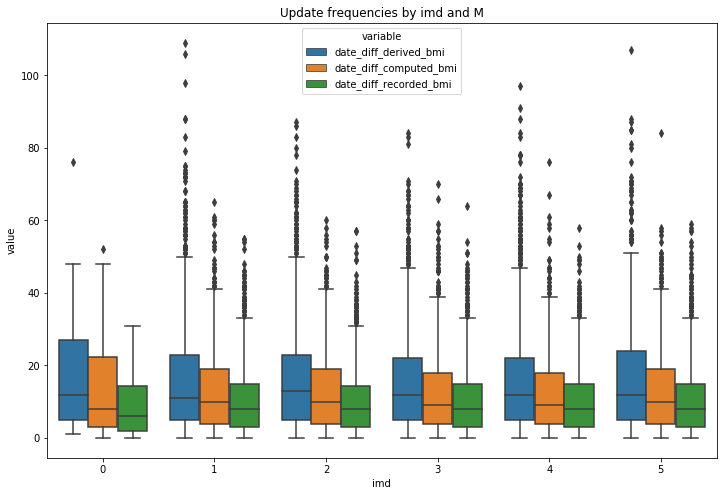

Average update frequencies by M:



,avg_date_diff_derived_bmi,avg_date_diff_computed_bmi,avg_date_diff_recorded_bmi,ct_date_diff_derived_bmi,ct_date_diff_computed_bmi,ct_date_diff_recorded_bmi
dementia,,,,,,
False,16.0613,12.7319,10.6552,6940,4430,5945
True,16.1944,15.1395,9.50877,70,45,55


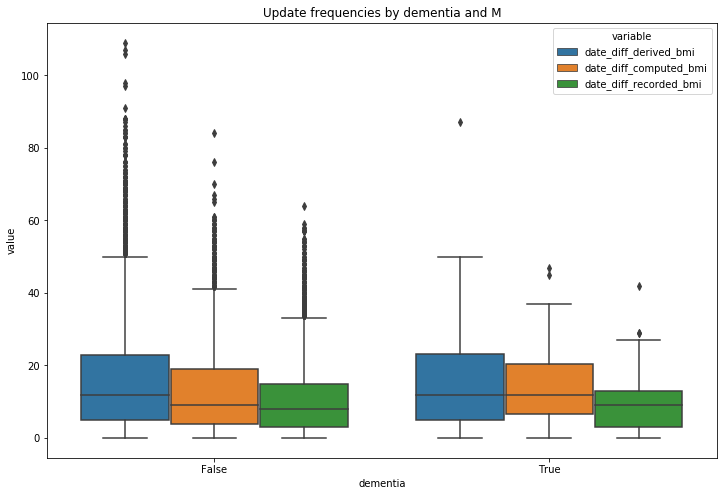

Average update frequencies by M:



,avg_date_diff_derived_bmi,avg_date_diff_computed_bmi,avg_date_diff_recorded_bmi,ct_date_diff_derived_bmi,ct_date_diff_computed_bmi,ct_date_diff_recorded_bmi
diabetes,,,,,,
False,16.0478,12.755,10.643,6945,4425,5940
True,17.6462,12.7647,10.7797,65,50,60


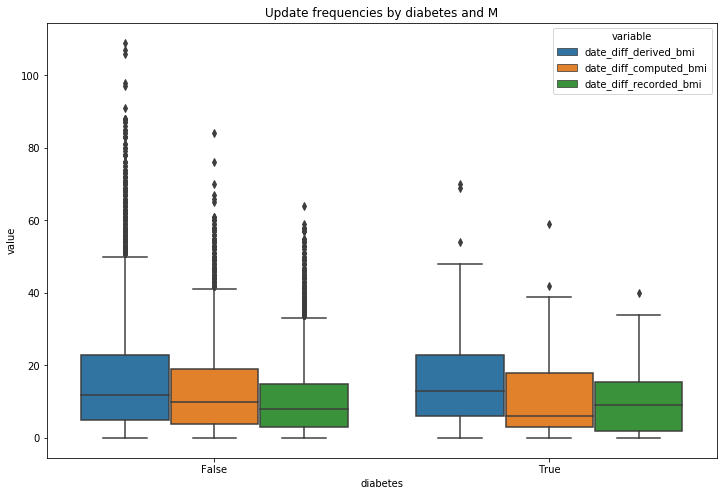

Average update frequencies by M:



,avg_date_diff_derived_bmi,avg_date_diff_computed_bmi,avg_date_diff_recorded_bmi,ct_date_diff_derived_bmi,ct_date_diff_computed_bmi,ct_date_diff_recorded_bmi
hypertension,,,,,,
False,16.0704,12.7531,10.6568,6940,4430,5940
True,15.2647,12.9545,9.42623,70,45,60


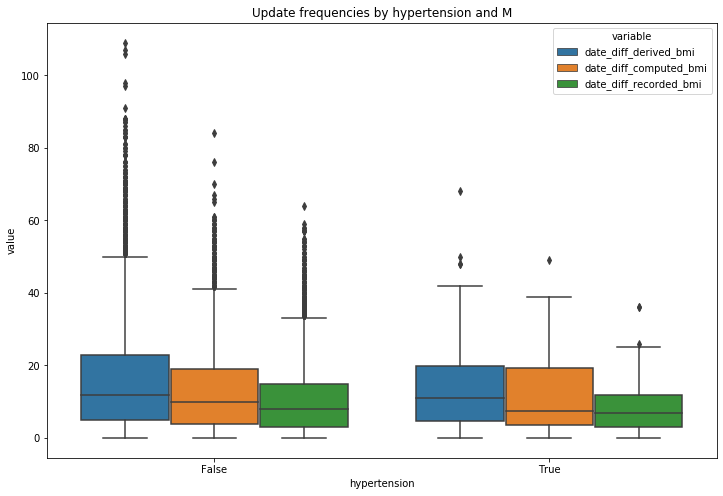

Average update frequencies by M:



,avg_date_diff_derived_bmi,avg_date_diff_computed_bmi,avg_date_diff_recorded_bmi,ct_date_diff_derived_bmi,ct_date_diff_computed_bmi,ct_date_diff_recorded_bmi
learning_disability,,,,,,
False,16.0517,12.7495,10.6403,6940,4430,5940
True,17.1765,13.2766,11.0328,70,45,60


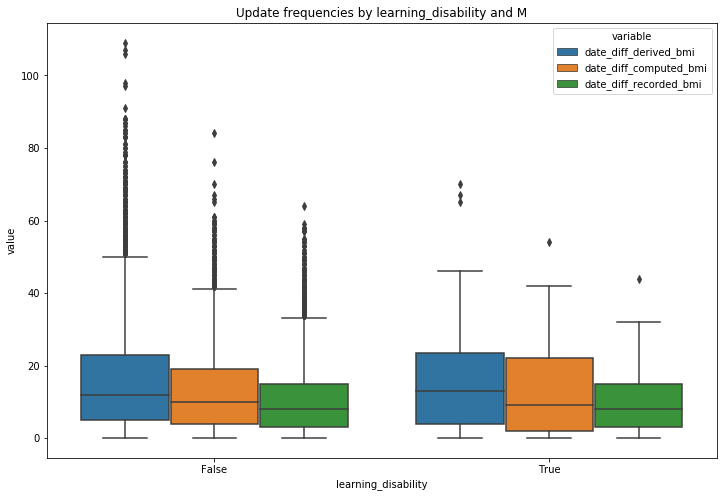

In [14]:
for group in demographic_covariates + clinical_covariates:
    report_update_frequency(df_clean, definitions, time_delta, len(definitions), group)